# Analyzing the Influenza Dataset

The influenza dataset downloaded [here](https://www.tycho.pitt.edu/dataset/US.6142004/). This is downloaded along with the relevant metadata in `data/influenza/US/*`. The dataset contains the following columns:

```
# 0  : "ConditionName"
# 1  : "ConditionSNOMED"
# 2  : "PathogenName"
# 3  : "PathogenTaxonID"
# 4  : "Fatalities"
# 5  : "CountryName"
# 6  : "CountryISO"
# 7  : "Admin1Name"
# 8  : "Admin1ISO"
# 9  : "Admin2Name"
# 10 : "CityName"
# 11 : "PeriodStartDate" YYYY-MM-DD
# 12 : "PeriodEndDate" YYYY-MM-DD
# 13 : "PartOfCumulativeCountSeries"
# 14 : "AgeRange"
# 15 : "Subpopulation"
# 16 : "PlaceOfAcquisition"
# 17 : "DiagnosisCertainty"
# 18 : "SourceName"
# 19 : "CountValue"
```

We notice a few things about the dataset:

* There is only one PathogenName in the dataset
* There is only one AgeRange in the dataset
* There are no DiagnosisCertainty values
* The CountValue column is sometimes a "Cummulative" value
  * See the [dataset readme](data/influenza/US/README.txt) under 'Separate cumulative from non-cumulative time interval series'
  * The PartOfCumulativeCountSeries is not provided in this dataset

Unique PathogenName Values
unidentified influenza virus


Unique AgeRange Values
0-130


Unique DiagnosisCertainty Values
NA


Unique PartOfCumulativeCountSeries Values
0


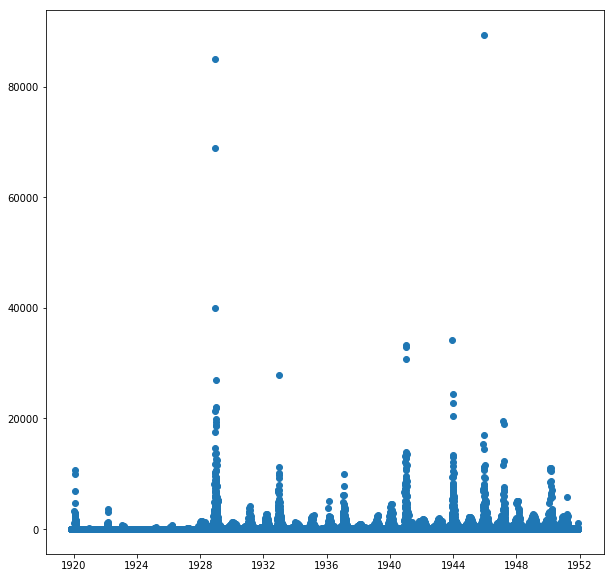

In [3]:
%run src/plots/unique_in_column.py 'data/influenza/US/US.6142004.csv' 'PathogenName'
%run src/plots/unique_in_column.py 'data/influenza/US/US.6142004.csv' 'AgeRange'
%run src/plots/unique_in_column.py 'data/influenza/US/US.6142004.csv' 'DiagnosisCertainty'
%run src/plots/unique_in_column.py 'data/influenza/US/US.6142004.csv' 'PartOfCumulativeCountSeries'
%run src/plots/date_plot.py 'data/influenza/US/US.6142004.csv' 'PeriodStartDate' 'CountValue'

## Sanitizing the Dataset

We first want to verify if `CountType` contains overlapping date intervals. We do so with a simple script below, and find many intervals with overlapping dates.


In [2]:
%run src/lib/cumulative_to_fixed_interval.py 'data/influenza/US/US.6142004.csv' 'PeriodStartDate' 'PeriodEndDate' 'CountValue'

Date range,Overlaps with
(1923-11-05) - (1923-11-11),(1923-11-04) - (1923-11-10)
(1937-05-23) - (1937-05-29),(1937-05-17) - (1937-05-23)
(1937-05-23) - (1937-05-29),(1937-05-17) - (1937-05-23)
(1923-11-05) - (1923-11-11),(1923-11-04) - (1923-11-10)
(1937-05-23) - (1937-05-29),(1937-05-17) - (1937-05-23)
(1937-05-23) - (1937-05-29),(1937-05-17) - (1937-05-23)
(1937-05-23) - (1937-05-29),(1937-05-17) - (1937-05-23)
(1937-05-23) - (1937-05-29),(1937-05-17) - (1937-05-23)
(1937-05-23) - (1937-05-29),(1937-05-17) - (1937-05-23)
(1937-05-23) - (1937-05-29),(1937-05-17) - (1937-05-23)


#### How to clean the dataset

Picking a row in the overlapping dateranges found above range values as an example:

```
"Influenza","6142004","unidentified influenza virus","11309","0","UNITED STATES OF AMERICA","US","PENNSYLVANIA","US-PA","PHILADELPHIA COUNTY","PHILADELPHIA","1923-11-04","1923-11-10","0","0-130","None specified","NA","NA","US Nationally Notifiable Disease Surveillance System","2"
"Influenza","6142004","unidentified influenza virus","11309","0","UNITED STATES OF AMERICA","US","PENNSYLVANIA","US-PA","PHILADELPHIA COUNTY","PHILADELPHIA","1923-11-05","1923-11-11","0","0-130","None specified","NA","NA","US Nationally Notifiable Disease Surveillance System","3"
```

We find:

* Between `"1923-11-04","1923-11-10"` there were `2` reported counts of Influenza (in Philadelphia)
* Between `"1923-11-05","1923-11-11"` there were `3` reported counts of Influenza


We want the data to be sanitized into the following format:
* Between `"1923-11-04","1923-11-11"` there were `3` reported counts of Influenza


We can do so by "squashing" the ranges:

Given two date ranges `[a1, a2]` and `[a3, a4]`, squash them into `[min(a1, a3), max(a2, a4)]` and use the largest reported count value.
